# Direct Marketing with Amazon SageMaker XGBoost and Hyperparameter Tuning (SageMaker API)
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_

---

---

Kernel `Python 3 (Data Science)` works well with this notebook.

## Contents

1. [Background](#Background)
1. [Prepration](#Preparation)
1. [Data Downloading](#Data_Downloading)
1. [Data Transformation](#Data_Transformation)
1. [Setup Hyperparameter Tuning](#Setup_Hyperparameter_Tuning)
1. [Launch Hyperparameter Tuning](#Launch_Hyperparameter_Tuning)
1. [Analyze Hyperparameter Tuning Results](#Analyze_Hyperparameter_Tuning_Results)
1. [Deploy The Best Model](#Deploy_The_Best_Model)


---

## Background
Direct marketing, either through mail, email, phone, etc., is a common tactic to acquire customers.  Because resources and a customer's attention is limited, the goal is to only target the subset of prospects who are likely to engage with a specific offer.  Predicting those potential customers based on readily available information like demographics, past interactions, and environmental factors is a common machine learning problem.

This notebook will train a model which can be used to predict if a customer will enroll for a term deposit at a bank, after one or more phone calls. Hyperparameter tuning will be used in order to try multiple hyperparameter settings and produce the best model.

---

## Preparation

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as SageMaker training.
- The IAM role used to give training access to your data. See SageMaker documentation for how to create these.

In [19]:
import sagemaker
import boto3

import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
from time import gmtime, strftime
import os

region = boto3.Session().region_name
smclient = boto3.Session().client("sagemaker")

role = sagemaker.get_execution_role()

bucket = "day08-mk-bhavesh"
prefix = "sagemaker/DEMO-hpo-xgboost-dm"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


---

## Data_Downloading
Let's start by downloading the [direct marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) from UCI's ML Repository.

In [20]:
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

--2023-11-10 01:58:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Last-modified header missing -- time-stamps turned off.
--2023-11-10 01:58:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Reusing existing connection to archive.ics.uci.edu:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

    [  <=>                                  ] 444,572     1.22MB/s   in 0.3s   

2023-11-10 01:58:47 (1.22 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
  inflating: bank-additional/.DS_Store  
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additio

Now lets read this into a Pandas data frame and take a look.

In [21]:
data = pd.read_csv("./bank-additional/bank-additional-full.csv", sep=";")
pd.set_option("display.max_columns", 500)  # Make sure we can see all of the columns
pd.set_option("display.max_rows", 50)  # Keep the output on one page
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


Let's talk about the data.  At a high level, we can see:

* We have a little over 40K customer records, and 20 features for each customer
* The features are mixed; some numeric, some categorical
* The data appears to be sorted, at least by `time` and `contact`, maybe more

_**Specifics on each of the features:**_

*Demographics:*
* `age`: Customer's age (numeric)
* `job`: Type of job (categorical: 'admin.', 'services', ...)
* `marital`: Marital status (categorical: 'married', 'single', ...)
* `education`: Level of education (categorical: 'basic.4y', 'high.school', ...)

*Past customer events:*
* `default`: Has credit in default? (categorical: 'no', 'unknown', ...)
* `housing`: Has housing loan? (categorical: 'no', 'yes', ...)
* `loan`: Has personal loan? (categorical: 'no', 'yes', ...)

*Past direct marketing contacts:*
* `contact`: Contact communication type (categorical: 'cellular', 'telephone', ...)
* `month`: Last contact month of year (categorical: 'may', 'nov', ...)
* `day_of_week`: Last contact day of the week (categorical: 'mon', 'fri', ...)
* `duration`: Last contact duration, in seconds (numeric). Important note: If duration = 0 then `y` = 'no'.
 
*Campaign information:*
* `campaign`: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
* `pdays`: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
* `previous`: Number of contacts performed before this campaign and for this client (numeric)
* `poutcome`: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)

*External environment factors:*
* `emp.var.rate`: Employment variation rate - quarterly indicator (numeric)
* `cons.price.idx`: Consumer price index - monthly indicator (numeric)
* `cons.conf.idx`: Consumer confidence index - monthly indicator (numeric)
* `euribor3m`: Euribor 3 month rate - daily indicator (numeric)
* `nr.employed`: Number of employees - quarterly indicator (numeric)

*Target variable:*
* `y`: Has the client subscribed a term deposit? (binary: 'yes','no')

## Data_Transformation
Cleaning up data is part of nearly every machine learning project.  It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process.  Several common techniques include:

* Handling missing values: Some machine learning algorithms are capable of handling missing values, but most would rather not.  Options include:
 * Removing observations with missing values: This works well if only a very small fraction of observations have incomplete information.
 * Removing features with missing values: This works well if there are a small number of features which have a large number of missing values.
 * Imputing missing values: Entire [books](https://www.amazon.com/Flexible-Imputation-Missing-Interdisciplinary-Statistics/dp/1439868247) have been written on this topic, but common choices are replacing the missing value with the mode or mean of that column's non-missing values.
* Converting categorical to numeric: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.
* Oddly distributed data: Although for non-linear models like Gradient Boosted Trees, this has very limited implications, parametric models like regression can produce wildly inaccurate estimates when fed highly skewed data.  In some cases, simply taking the natural log of the features is sufficient to produce more normally distributed data.  In others, bucketing values into discrete ranges is helpful.  These buckets can then be treated as categorical variables and included in the model when one hot encoded.
* Handling more complicated data types: Mainpulating images, text, or data at varying grains.

Luckily, some of these aspects have already been handled for us, and the algorithm we are showcasing tends to do well at handling sparse or oddly distributed data.  Therefore, let's keep pre-processing simple.

First of all, Many records have the value of "999" for pdays, number of days that passed by after a client was last contacted. It is very likely to be a magic number to represent that no contact was made before. Considering that, we create a new column called "no_previous_contact", then grant it value of "1" when pdays is 999 and "0" otherwise.

In the "job" column, there are categories that mean the customer is not working, e.g., "student", "retire", and "unemployed". Since it is very likely whether or not a customer is working will affect his/her decision to enroll in the term deposit, we generate a new column to show whether the customer is working based on "job" column.

Last but not the least, we convert categorical to numeric, as is suggested above.

In [22]:
data["no_previous_contact"] = np.where(
    data["pdays"] == 999, 1, 0
)  # Indicator variable to capture when pdays takes a value of 999
data["not_working"] = np.where(
    np.in1d(data["job"], ["student", "retired", "unemployed"]), 1, 0
)  # Indicator for individuals not actively employed
model_data = pd.get_dummies(data)  # Convert categorical variables to sets of indicators
model_data

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,Fals

Another question to ask yourself before building a model is whether certain features will add value in your final use case.  For example, if your goal is to deliver the best prediction, then will you have access to that data at the moment of prediction?  Knowing it's raining is highly predictive for umbrella sales, but forecasting weather far enough out to plan inventory on umbrellas is probably just as difficult as forecasting umbrella sales without knowledge of the weather.  So, including this in your model may give you a false sense of precision.

Following this logic, let's remove the economic features and `duration` from our data as they would need to be forecasted with high precision to use as inputs in future predictions.

Even if we were to use values of the economic indicators from the previous quarter, this value is likely not as relevant for prospects contacted early in the next quarter as those contacted later on.

In [23]:
model_data = model_data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)

We'll then split the dataset into training (70%), validation (20%), and test (10%) datasets and convert the datasets to the right format the algorithm expects. We will use training and validation datasets during training. Test dataset will be used to evaluate model performance after it is deployed to an endpoint.

Amazon SageMaker's XGBoost algorithm expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [24]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)

pd.concat([train_data["y_yes"], train_data.drop(["y_no", "y_yes"], axis=1)], axis=1).to_csv(
    "train.csv", index=False, header=False
)
pd.concat(
    [validation_data["y_yes"], validation_data.drop(["y_no", "y_yes"], axis=1)], axis=1
).to_csv("validation.csv", index=False, header=False)
pd.concat([test_data["y_yes"], test_data.drop(["y_no", "y_yes"], axis=1)], axis=1).to_csv(
    "test.csv", index=False, header=False
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Now we'll copy the file to S3 for Amazon SageMaker training to pickup.

In [25]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

---

## Setup_Hyperparameter_Tuning 
*Note, with the default setting below, the hyperparameter tuning job can take about 30 minutes to complete.*

Now that we have prepared the dataset, we are ready to train models. Before we do that, one thing to note is there are algorithm settings which are called "hyperparameters" that can dramtically affect the performance of the trained models. For example, XGBoost algorithm has dozens of hyperparameters and we need to pick the right values for those hyperparameters in order to achieve the desired model training results. Since which hyperparameter setting can lead to the best result depends on the dataset as well, it is almost impossible to pick the best hyperparameter setting without searching for it, and a good search algorithm can search for the best hyperparameter setting in an automated and effective way.

We will use SageMaker hyperparameter tuning to automate the searching process effectively. Specifically, we specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune. SageMaker hyperparameter tuning will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will give it a budget (max number of training jobs) and it will complete once that many training jobs have been executed.

Now we configure the hyperparameter tuning job by defining a JSON object that specifies following information:
* The ranges of hyperparameters we want to tune
* Number of training jobs to run in total and how many training jobs should be run simultaneously. More parallel jobs will finish tuning sooner, but may sacrifice accuracy. We recommend you set the parallel jobs value to less than 10% of the total number of training jobs (we'll set it higher just for this example to keep it short).
* The objective metric that will be used to evaluate training results, in this example, we select *validation:auc* to be the objective metric and the goal is to maximize the value throughout the hyperparameter tuning process. One thing to note is the objective metric has to be among the metrics that are emitted by the algorithm during training. In this example, the built-in XGBoost algorithm emits a bunch of metrics and *validation:auc* is one of them. If you bring your own algorithm to SageMaker, then you need to make sure whatever objective metric you select, your algorithm actually emits it.

We will tune four hyperparameters in this examples:
* *eta*: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative. 
* *alpha*: L1 regularization term on weights. Increasing this value makes models more conservative. 
* *min_child_weight*: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is. 
* *max_depth*: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted. 

Evaluation metrics for XGBoost is in this URL:
https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html

In [26]:
from time import gmtime, strftime, sleep

tuning_job_name = "xgboost-tuningjob-" + strftime("%d-%H-%M-%S", gmtime())

print(tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "1",
                "MinValue": "0",
                "Name": "eta",
            },
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "min_child_weight",
            },
            {
                "MaxValue": "2",
                "MinValue": "0",
                "Name": "alpha",
            },
        ],
        "IntegerParameterRanges": [
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "max_depth",
            }
        ],
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 10, "MaxParallelTrainingJobs": 3},
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:mse", "Type": "Minimize"},
}

xgboost-tuningjob-10-01-59-41


Then we configure the training jobs the hyperparameter tuning job will launch by defining a JSON object that specifies following information:
* The container image for the algorithm (XGBoost)
* The input configuration for the training and validation data
* Configuration for the output of the algorithm
* The values of any algorithm hyperparameters that are not tuned in the tuning job (StaticHyperparameters)
* The type and number of instances to use for the training jobs
* The stopping condition for the training jobs

Again, since we are using built-in XGBoost algorithm here, it emits two predefined metrics: *validation:auc* and *train:auc*, and we elected to monitor *validation_auc* as you can see above. One thing to note is if you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a MetricDefinition object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics.

In [27]:
from sagemaker.image_uris import retrieve

training_image = retrieve(framework="xgboost", region=region, version="1.5-1")

s3_input_train = "s3://{}/{}/train".format(bucket, prefix)
s3_input_validation = "s3://{}/{}/validation/".format(bucket, prefix)

training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,
                }
            },
        },
        {
            "ChannelName": "validation",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "RoleArn": role,
    "StaticHyperParameters": {
        "eval_metric": "auc",
        "num_round": "100",
        "objective": "binary:hinge",
        "rate_drop": "0.3",
        "tweedie_variance_power": "1.4",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}

## Launch_Hyperparameter_Tuning
Now we can launch a hyperparameter tuning job by calling create_hyper_parameter_tuning_job API. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [28]:
smclient.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:311247560489:hyper-parameter-tuning-job/xgboost-tuningjob-10-01-59-41',
 'ResponseMetadata': {'RequestId': '5e307e24-3460-4184-afe0-fdf650e8a41b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5e307e24-3460-4184-afe0-fdf650e8a41b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Fri, 10 Nov 2023 02:04:36 GMT'},
  'RetryAttempts': 0}}

Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [29]:
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)[
    "HyperParameterTuningJobStatus"
]

'Completed'

In [30]:
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobName']

'xgboost-tuningjob-10-01-59-41'

### Important: ### 
Wait until the hyperparameter job is done. You can go to console and see if 10 jobs are completed or not. Alternatovely you have to re-run the folling code until you see 10 training jobs have completed. 

In [31]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

10 training jobs have completed


Although you can find that in the console, you can also query the best training job programmatically:

In [32]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 11, 10, 2, 4, 42, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mse',
                                                 'Value': 1.1026899814605713},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 11, 10, 2, 9, 1, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:311247560489:training-job/xgboost-tuningjob-10-01-59-41-001-2c254fa9',
 'TrainingJobName': 'xgboost-tuningjob-10-01-59-41-001-2c254fa9',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 11, 10, 2, 7, 9, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.4504916951086293',
                          'eta': '0.3100443606024935',
                          'max_depth': '3',
                          'min_child_weight': '1.0002521318610684'}}


## Fetch all results as DataFrame
We can actully see all the training jobs and list hyperparameters and objective metrics and pick up the training job with the best objective metric.

In [68]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

full_df

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Number of training jobs with valid objective: 1
{'lowest': 1.0812699794769287, 'highest': 1.0812699794769287}


,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,1.334306,mul-xgboost-tuningjob10-03-41-45-001-409938d2,Completed,1.08127,2023-11-10 03:43:41+00:00,2023-11-10 03:45:38+00:00,117.0


## See TuningJob results vs time
Next we will show how the objective metric changes over time, as the tuning job progresses.  For Bayesian strategy, you should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance _exploration_ of new areas of parameter space against _exploitation_ of known good areas.  This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [34]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool


class HoverHelper:
    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append((k, "@{%s}" % k))

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools="pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset"):
        return [self.hovertool(), standard_tools]


hover = HoverHelper(tuner)

p = figure(width=900, height=400, tools=hover.tools(), x_axis_type="datetime")
p.circle(source=df, x="TrainingStartTime", y="FinalObjectiveValue")
show(p)

Loading BokehJS ...

## Analyze the correlation between objective metric and individual hyperparameters
Now you have finished a tuning job, you may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For example, if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with your objective metric.

In [35]:
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get("Values"):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0

        vals = hp_range["Values"]
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args["x_range"] = vals

    # Now plot it
    p = figure(
        width=500,
        height=500,
        title="Objective vs %s" % hp_name,
        tools=hover.tools(),
        x_axis_label=hp_name,
        y_axis_label=objective_name,
        **categorical_args,
    )
    p.circle(source=df, x=hp_name, y="FinalObjectiveValue")
    figures.append(p)
show(bokeh.layouts.Column(*figures))

## Deploy the best model (Optional)
Now that we have got the best model, we can deploy it to an endpoint. Please refer to other SageMaker sample notebooks or SageMaker documentation to see how to deploy a model.

In [38]:
import pandas as pd

# Select the columns of interest
columns_of_interest = ['alpha', 'eta', 'max_depth', 'min_child_weight', 'FinalObjectiveValue']
subset_df = full_df[columns_of_interest]

# Calculate the correlation matrix
corr_matrix = subset_df.corr()

# Print or display the correlation matrix
print(corr_matrix)

                        alpha       eta  max_depth  min_child_weight  \
alpha                1.000000 -0.468066   0.013244          0.226571   
eta                 -0.468066  1.000000   0.183799          0.311059   
max_depth            0.013244  0.183799   1.000000          0.508419   
min_child_weight     0.226571  0.311059   0.508419          1.000000   
FinalObjectiveValue -0.762760  0.744584   0.272426          0.084619   

                     FinalObjectiveValue  
alpha                          -0.762760  
eta                             0.744584  
max_depth                       0.272426  
min_child_weight                0.084619  
FinalObjectiveValue             1.000000  


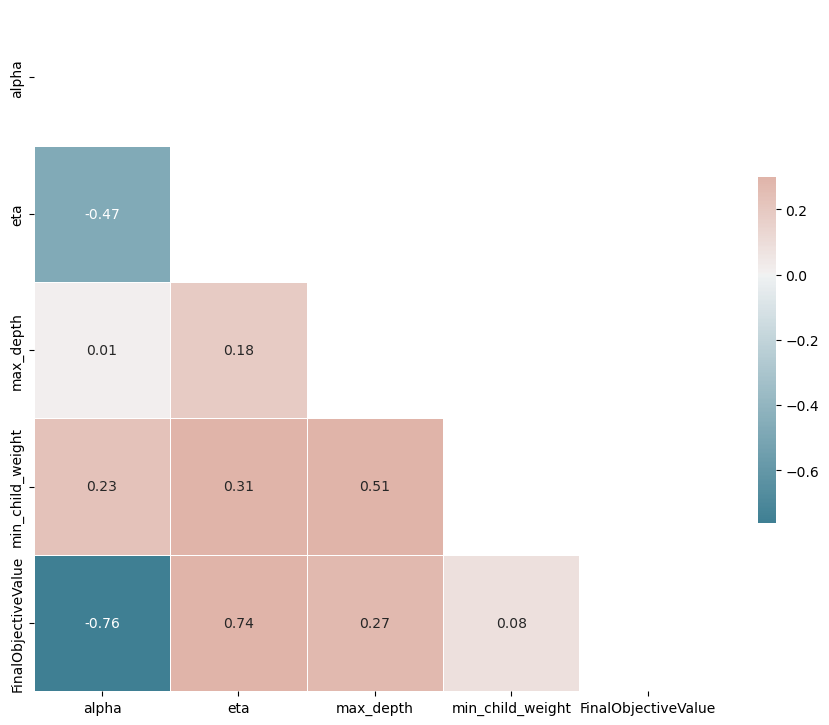

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Observation:

- If alpha is High  then Final Objective Value will be low as they have a negative coorelation of -0.76.

- If eta high then then Final Objective Value will be high and eta low then the Final Objective Value will be low, as they have a positive coorelation of 0.74.

- If Max depth high then Final Objective Value will be high as they have a positive coorelation of 0.27.

- min_child_weight is almost close to 0 0.08 so it has a very low positive coorelation with the Final Objective Value.

In [59]:
from time import gmtime, strftime, sleep

tuning_job_name = "mul-xgboost-tuningjob" + strftime("%d-%H-%M-%S", gmtime())

print(tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "2",
                "MinValue": "1",
                "Name": "min_child_weight",
            },
        ],
        "IntegerParameterRanges": [],
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 1, "MaxParallelTrainingJobs": 1},
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:mse", "Type": "Minimize"},
}

mul-xgboost-tuningjob10-03-41-45


In [60]:
from sagemaker.image_uris import retrieve

training_image = retrieve(framework="xgboost", region=region, version="1.5-1")

s3_input_train = "s3://{}/{}/train".format(bucket, prefix)
s3_input_validation = "s3://{}/{}/validation/".format(bucket, prefix)

training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,
                }
            },
        },
        {
            "ChannelName": "validation",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "RoleArn": role,
    "StaticHyperParameters": {
        "eval_metric": "auc",
        "num_round": "100",
        "objective": "binary:hinge",
        "rate_drop": "0.3",
        "tweedie_variance_power": "1.4",
        "alpha":"1.95",
        "eta":"0.11",
        "max_depth":"5",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}

In [61]:
smclient.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:311247560489:hyper-parameter-tuning-job/mul-xgboost-tuningjob10-03-41-45',
 'ResponseMetadata': {'RequestId': '66e97c4f-5182-460b-8802-07fcaa99eb3e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '66e97c4f-5182-460b-8802-07fcaa99eb3e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '133',
   'date': 'Fri, 10 Nov 2023 03:41:48 GMT'},
  'RetryAttempts': 0}}

In [63]:
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)[
    "HyperParameterTuningJobStatus"
]

'Completed'

In [64]:
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobName']

'mul-xgboost-tuningjob10-03-41-45'

In [65]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

1 training jobs have completed


In [66]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 11, 10, 3, 41, 53, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mse',
                                                 'Value': 1.0812699794769287},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 11, 10, 3, 45, 38, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:311247560489:training-job/mul-xgboost-tuningjob10-03-41-45-001-409938d2',
 'TrainingJobName': 'mul-xgboost-tuningjob10-03-41-45-001-409938d2',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 11, 10, 3, 43, 41, tzinfo=tzlocal()),
 'TunedHyperParameters': {'min_child_weight': '1.3343061346180045'}}


In [129]:
import pandas as pd

sm_client = boto3.client('sagemaker')

tuning_job_name = 'xgboost-tuningjob-10-01-59-41'
tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df_1 = tuner_1.dataframe()

tuning_job_name_2 = 'mul-xgboost-tuningjob10-03-41-45'
tuner_2 = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name_2)
full_df_2 = tuner_2.dataframe()

response = sm_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name_2)
hyperparameters = response['TrainingJobDefinition']['StaticHyperParameters']
hyperparameters

# Extract alpha, eta, and max_depth
alpha_value = float(hyperparameters.get('alpha', 0.0))
eta_value = float(hyperparameters.get('eta', 0.0))
max_depth_value = int(hyperparameters.get('max_depth', 0))

# Add the additional columns and values to the existing DataFrame (full_df_2)
full_df_2['alpha'] = alpha_value
full_df_2['eta'] = eta_value
full_df_2['max_depth'] = max_depth_value


full_df_2

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,alpha,eta,max_depth
0,1.334306,mul-xgboost-tuningjob10-03-41-45-001-409938d2,Completed,1.08127,2023-11-10 03:43:41+00:00,2023-11-10 03:45:38+00:00,117.0,1.95,0.11,5


In [130]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool


class HoverHelper:
    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append((k, "@{%s}" % k))

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools="pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset"):
        return [self.hovertool(), standard_tools]


hover = HoverHelper(tuner)

p = figure(width=900, height=400, tools=hover.tools(), x_axis_type="datetime")
p.circle(source=df, x="TrainingStartTime", y="FinalObjectiveValue")
show(p)

Loading BokehJS ...

In [131]:
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get("Values"):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0

        vals = hp_range["Values"]
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args["x_range"] = vals

    # Now plot it
    p = figure(
        width=500,
        height=500,
        title="Objective vs %s" % hp_name,
        tools=hover.tools(),
        x_axis_label=hp_name,
        y_axis_label=objective_name,
        **categorical_args,
    )
    p.circle(source=df, x=hp_name, y="FinalObjectiveValue")
    figures.append(p)
show(bokeh.layouts.Column(*figures))